<a href="https://colab.research.google.com/github/Jaguaribe002/yolo/blob/main/vehicle_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun May  4 18:57:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import time  # Importa o módulo time

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [4]:
# importa dataset do próprio drive (colab funciona na nuvem)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/yolo_vehicles/  #!ls lista todos os arquivos dentro de um diretório

datasets


In [6]:
!cp -r /content/drive/MyDrive/yolo_vehicles/datasets/ ./

In [7]:
# determina as coordenadas das bounding boxes do yolo (desenha as bboxes a partir dos valores máximos e mínimos de x e y)
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [8]:
def plot_box(image, bboxes, labels):
    # precisa das dimensões da imagem para dimensionar as bboxes
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):  # pega o índice e o valor da bbox
        x1, y1, x2, y2 = yolo2bbox(box)
        # coordenadas escritas em função das dimensões da imagem
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )  #retorna a bbox como um retângulo que circunda o objeto
    return image

    # essas duas funções desenham as caixas delimitadoras. A primeira descreve os tamanhos máximo e mínimo que ela pode assumir
  # a segunda desenha o tamanho e a grossura das caixas segundo as dimensões da imagem, retornando a imagem circundada pela caixa

In [9]:
# função carrega uma imagem a partir do path da imagem, do path do label dos objetos da imagem e ainda precisa de um número de amostras
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.png'))  # adiciona à lista "all_images" todos os arquivos tipo png e jpg
    all_images.extend(glob.glob(image_paths+'/*.PNG'))
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()  # ordena em ordem crescente numérica os paths das imagens

    num_images = len(all_images)  # numero de imagens é o comprimento da lista com todas as imagens

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)  # j é um número aleatório gerado dentro dos possíveis índices das imagens na lista
        image_name = all_images[j]  # coleta imagem com índice referente ao número j
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1]) # dividir imagem do "." (forma uma string com tudo antes de .png e .jpg)
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:  # chama label da imagem referente ao seu nome sem final .jpg ou .png (final na verdade é .txt)
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                parts = label_line.strip().split()
                label = parts[0]
                bbox_string = parts[1:]
                if len(bbox_string) == 4:  # Assegura que as bboxes tem 4 coordenadas
                    x_c, y_c, w, h = map(float, bbox_string)  # converte cada coordenada em float
                    bboxes.append([x_c, y_c, w, h])
                    labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

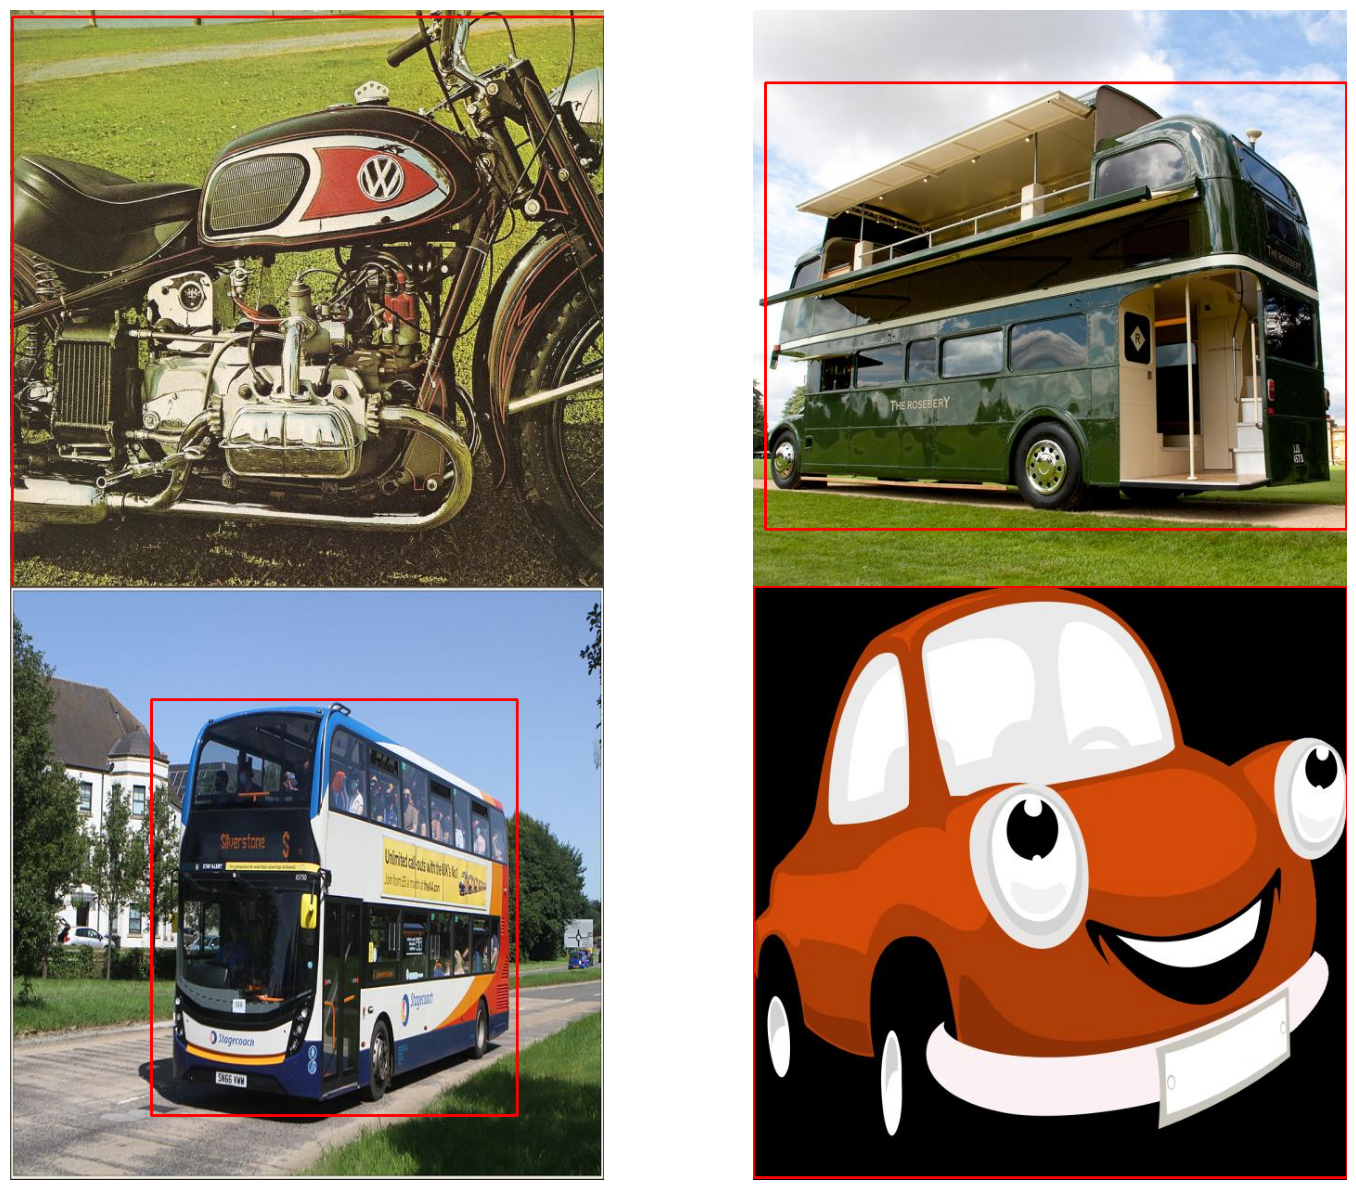

In [10]:
# visualisar imagens de treinamento
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=4,
)

In [11]:
%%writefile vehicles.yaml
train: '/content/drive/MyDrive/yolo_vehicles/datasets/train'  # determina path para as imagens de treinamento
val: '/content/drive/MyDrive/yolo_vehicles/datasets/valid'      # determina path para as imagens de validação
nc: 5

# nome das classes
names: ['airplane', 'bike', 'bus', 'car', 'motorcycle']


Writing vehicles.yaml


In [12]:
import glob
import os

# função para corrigir o índice dos labels no dataset
def correct_class_index(label_dir, original_index, correct_index):
    # cria uma lista com todos os labels do dataset (acabam em .txt)
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))

    # loop para cada arquivo
    for label_file in label_files:
        # leitura do conteúdo dos arquivos
        with open(label_file, 'r') as file:
            labels = file.readlines()

        # susbstituir índice de cada label para 0
        corrected_labels = [label.replace(f'{original_index} ', f'{correct_index} ') for label in labels]

        # escrever labels corrigidos nos arquivos
        with open(label_file, 'w') as file:
            file.writelines(corrected_labels)

# path para os labels
train_labels = '/content/drive/MyDrive/yolo_algae/datasets/train/labels'
valid_labels = '/content/drive/MyDrive/yolo_algae/datasets/valid/labels'

# corrigir índices de 2 para 0 (sempre para 0)
correct_class_index(train_labels, 2, 0)
correct_class_index(valid_labels, 2, 0)
correct_class_index(train_labels, 3, 0)
correct_class_index(valid_labels, 3, 0)
correct_class_index(train_labels, 4, 0)
correct_class_index(valid_labels, 4, 0)
correct_class_index(train_labels, 1, 0)
correct_class_index(valid_labels, 1, 0)

KeyboardInterrupt: 

In [14]:
# Inicia a medição do tempo
start_time = time.time()

# Sample training for 150 epoch.
EPOCHS = 150

# calling pre-trained model
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data=vehicles.yaml epochs={EPOCHS} batch=8 name=yolov8s_v8_50e

end_time = time.time()

print(f"Tempo de treinamento: {end_time - start_time} segundos")


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=vehicles.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_v8_50e2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

In [16]:
!yolo task=detect mode=val model=runs/detect/yolov8s_v8_50e2/weights/best.pt name=yolov8s_eval data= vehicles.yaml

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 25.4±13.4 MB/s, size: 52.0 KB)
val: Scanning /content/drive/MyDrive/yolo_vehicles/datasets/valid/labels.cache... 202 images, 0 backgrounds, 0 corrupt: 100% 202/202 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:10<00:00,  1.20it/s]
                   all        202        310      0.855       0.64       0.77      0.424
              airplane         34         50      0.806       0.54      0.719      0.306
                  bike         32         38      0.803      0.711      0.778      0.377
                   bus         47         55      0.907      0.855      0.893      0.523
                   car         64         90      0.861      0.551      0.685      0.437
            motorcycle         37

In [18]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8s_v8_50e2/weights/best.pt \
source=datasets/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in in the future. Use 'show_labels' instead.
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs

image 1/202 /content/datasets/valid/images/0102bf64-ba15-44ad-b296-21a9836d9edc_jpg.rf.9f6e3b0737bdb388b6097c7d9d80896d.jpg: 1280x1280 1 motorcycle, 47.6ms
image 2/202 /content/datasets/valid/images/01d653b3-8198-4f41-8714-ad7e5da60d8d_jpg.rf.9bc11eac38e9af3578745344137adc9a.jpg: 1280x1280 2 cars, 41.6ms
image 3/202 /content/datasets/valid/images/01e9793f-3e09-4f7d-8d53-acc7ebec44ac_jpg.rf.a2167de56322f4469f54150edb7683f1.jpg: 1280x1280 1 airplane, 41.3ms
image 4/202 /content/datasets/valid/images/054fee0f-45e7-41a5-b468-25f0ea49febe_jpg.rf.7fe0b79e8c3d61b55b691b3d24cc9f6a.jpg: 1280x1280 1 car, 41.3ms
image 5/202 /content/datasets/valid/images/062697ff-7ee3-4a53-a686-5256447b2f1f_jpg.rf.715237f196dd386ad78badb82cbd7312.j

In [19]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

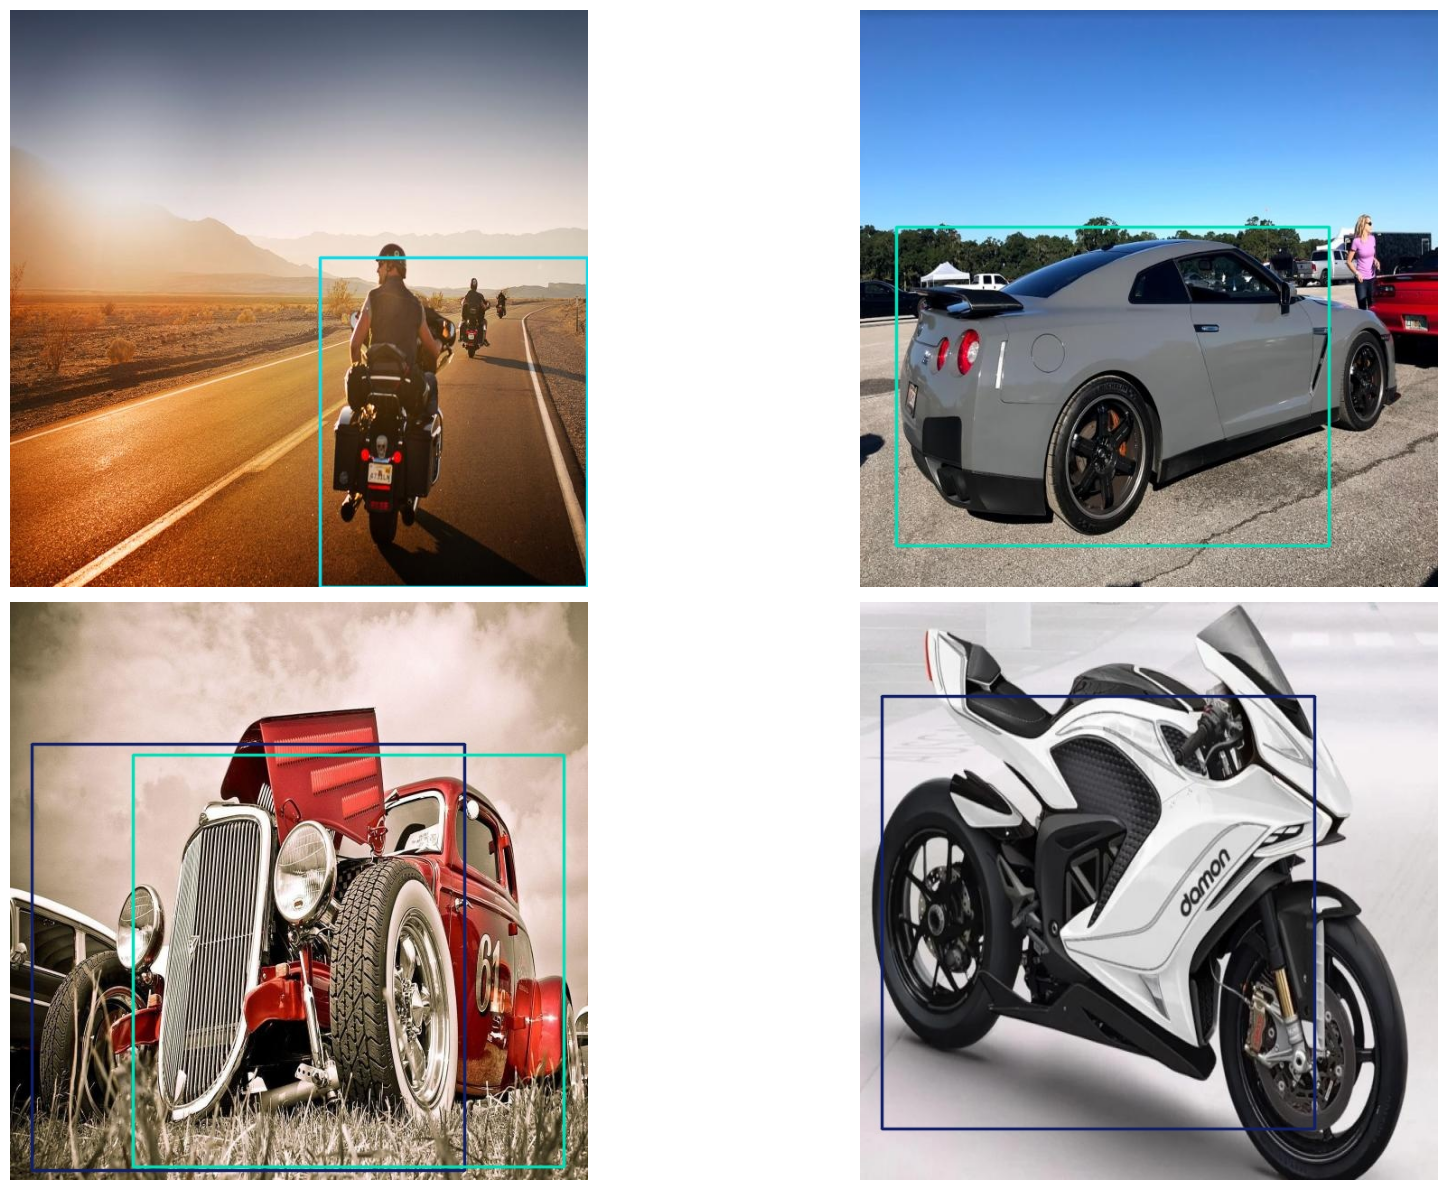

In [23]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')